# Projeto Marinha do Brasil

## Laboratório de Processamento de Sinais - UFRJ

### Autor: Vinícius dos Santos Mello <viniciusdsmello@poli.ufrj.br>

In [1]:
import os
import sys
import time
sys.path.insert(0,'..')

from noveltyDetectionConfig import CONFIG
import numpy as np
import itertools
import multiprocessing

from Functions.email_utils import EmailConnection, Email
from SAENoveltyDetectionAnalysis import SAENoveltyDetectionAnalysis

num_processes = multiprocessing.cpu_count()

# Enviroment variables
data_path = CONFIG['OUTPUTDATAPATH']
results_path = CONFIG['PACKAGE_NAME']

training_params = {
    "Technique": "StackedAutoEncoder",
    "TechniqueParameters": {
        "allow_change_weights": False
    },
    "DevelopmentMode": False,
    "DevelopmentEvents": 400,
    "NoveltyDetection": True,
    "InputDataConfig": {
        "database": "4classes",
        "n_pts_fft": 1024,
        "decimation_rate": 3,
        "spectrum_bins_left": 400,
        "n_windows": 1,
        "balance_data": False
    },
    "OptmizerAlgorithm": {
        "name": "Adam",
        "parameters": {
            "learning_rate": 0.001,
            "beta_1": 0.90,
            "beta_2": 0.999,
            "epsilon": 1e-08,
            "learning_decay": 1e-6,
            "momentum": 0.3,
            "nesterov": True
        }
    },
    "HyperParameters": {
        "n_folds": 10,
        "n_epochs": 300,
        "n_inits": 2,
        "batch_size": 256,
        "kernel_initializer": "uniform",
        "encoder_activation_function": "tanh", #"relu",
        "decoder_activation_function": "linear",
        "classifier_output_activation_function": "softmax",
        "norm": "mapstd",
        "metrics": ["accuracy"],
        "loss": "mean_squared_error",
        "dropout": False,
        "dropout_parameter": 0,
        "regularization": None,
        "regularization_parameter": 0
    },
    "callbacks": {
        "EarlyStopping": {
            "patience": 30,
            "monitor": "val_loss"
        }
    }
}
analysis = SAENoveltyDetectionAnalysis(parameters=training_params, model_hash="", load_hash=False, load_data=True, verbose=True)
all_data, all_trgt, trgt_sparse = analysis.getData()

Using TensorFlow backend.


[+] Time to read data file: 1.05647993088 seconds
Qtd event of A is 12939
Qtd event of B is 29352
Qtd event of C is 11510
Qtd event of D is 23760

Biggest class is B with 29352 events
Total of events in the dataset is 77561
Reading from /home/vinicius.mello/Workspace/SonarAnalysis_2/Results/NoveltyDetection/StackedAutoEncoder/outputs/10_folds_cross_validation.jbl


#### Initialize objects of StackedAutoEncoder class for all models with its corresponding novelty class

In [2]:
SAE = analysis.createSAEModels()

#### Perform the training of the model

In [ ]:
trn_data = analysis.trn_data
trn_trgt = analysis.trn_trgt
trn_trgt_sparse = analysis.trn_trgt_sparse

inovelty = 0

data=trn_data[inovelty]
trgt=trn_trgt[inovelty]

SAE[inovelty].train_classifier(data  = data,
                               trgt  = trgt,
                               ifold = 0,
                               hidden_neurons = [200,1],
                               layer = 2)

# def train(fold):
#         SAE[inovelty].trainClassifier(data  = data,
#                                       trgt  = trgt,
#                                       ifold = fold,
#                                       hidden_neurons = hidden_neurons,
#                                       layer = layer,
#                                       regularizer=regularizer,
#                                       regularizer_param=regularizer_param)
#         p = multiprocessing.Pool(processes=num_processes)

#         results = p.map(train, range(analysis.n_folds))

#         p.close()
#         p.join()

In [6]:
trn_data = analysis.trn_data
trn_trgt = analysis.trn_trgt
trn_trgt_sparse = analysis.trn_trgt_sparse

for inovelty in range(len(analysis.class_labels)):
    startTime = time.time()
    
    data=trn_data[inovelty]
    trgt=trn_trgt[inovelty]

    analysis.train(layer=2,
                   inovelty=inovelty,
                   fineTuning=True,
                   trainingType="neuronSweep", #foldSweep, neuronSweep, normal
                   hidden_neurons=[200,200],
                   neurons_variation_step=50,
                   numThreads=10,
                   model_hash=analysis.model_hash)
    
    name = "Vinícius Mello"
    email = "viniciusdsmello@gmail.com"
    password = "duqmnajvpwrdnvvv"
    mail_server = "smtp.gmail.com"
    
    to_email = "viniciusdsmello@lps.ufrj.br"
    to_name = "Vinícius Mello"
    
    subject = '[Projeto Sonar] - Treinamento de modelo concluído'
    message = "The training of the model for novelty class"\
    "{0} took {1} seconds to be performed\n".format(analysis.class_labels[inovelty], time.time() - startTime)
    attachments = []
    server = EmailConnection(mail_server, email, password)
    email = Email(from_='"%s" <%s>' % (name, email), #you can pass only email
                  to='"%s" <%s>' % (to_name, to_email), #you can pass only email
                  subject=subject, message=message, attachments=attachments)
    server.send(email)
    server.close()
    print "The training of the model for novelty class {0} took {1} seconds to be performed\n".format(analysis.class_labels[inovelty], time.time() - startTime)

python modelTrain.py --layer 2 --novelty 0 --finetunning 1 --threads 10 --type neuronSweep --hiddenNeurons 200x200 --neuronsVariationStep 50 --modelhash 91ca9d350b4b604c840062a024f485ac28e1499c5b18a0c1eff59b7489194c81
The training of the model for novelty class A took 3326.33649588 seconds to be performed

python modelTrain.py --layer 2 --novelty 1 --finetunning 1 --threads 10 --type neuronSweep --hiddenNeurons 200x200 --neuronsVariationStep 50 --modelhash 91ca9d350b4b604c840062a024f485ac28e1499c5b18a0c1eff59b7489194c81
The training of the model for novelty class B took 3104.26687503 seconds to be performed

python modelTrain.py --layer 2 --novelty 2 --finetunning 1 --threads 10 --type neuronSweep --hiddenNeurons 200x200 --neuronsVariationStep 50 --modelhash 91ca9d350b4b604c840062a024f485ac28e1499c5b18a0c1eff59b7489194c81
The training of the model for novelty class C took 4016.23939204 seconds to be performed

python modelTrain.py --layer 2 --novelty 3 --finetunning 1 --threads 10 --ty

# Pre-training analysis

### Mean Squared Error analysis for Pre-training Step with a neuron variation at autoencoder

In [3]:
# Neuron variation x MSE Divergence
%matplotlib inline 

from sklearn import metrics
from sklearn import preprocessing
from sklearn.externals import joblib
from Functions.StatisticalAnalysis import KLDiv, EstPDF
import matplotlib.pyplot as plt

# Choose layer 
layer = 2

# Choose neurons topology
# hidden_neurons = range(400,0,-50) + [2]
hidden_neurons = [200,200]

step = 50
neurons_mat = [1] + range(step,hidden_neurons[layer-1]+step,step)
neurons_mat = neurons_mat[:len(neurons_mat)-layer+2]

analysis_name = 'mean_squared_error_%i_layer_keras_class_weights'%(layer)
analysis_file = os.path.join(analysis.getBaseResultsPath(), "AnalysisFiles", analysis_name + ".jbl")    

verbose = True

# Plot parameters
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['legend.handlelength'] = 3
plt.rcParams['legend.borderpad'] = 0.3
plt.rcParams['legend.fontsize'] = 14
m_colors = ['b', 'r', 'g', 'y']
figsize = (10,5)

mse = {}
mse_known = np.zeros([len(analysis.class_labels), analysis.n_folds, len(neurons_mat)])
mse_novelty = np.zeros([len(analysis.class_labels), analysis.n_folds, len(neurons_mat)])

if not os.path.exists(analysis_file):
    for inovelty in range(len(analysis.class_labels)):
        n_bins = 100
        for ineuron in neurons_mat: 
            if ineuron == 0:
                ineuron = 1
            def getMSE(ifold):
                train_id, test_id = analysis.CVO[inovelty][ifold]

                # normalize known classes
                if analysis.parameters["HyperParameters"]["norm"] == "mapstd":
                    scaler = preprocessing.StandardScaler().fit(all_data[all_trgt!=inovelty][train_id,:])
                elif analysis.parameters["HyperParameters"]["norm"] == "mapstd_rob":
                    scaler = preprocessing.RobustScaler().fit(all_data[all_trgt!=inovelty][train_id,:])
                elif analysis.parameters["HyperParameters"]["norm"] == "mapminmax":
                    scaler = preprocessing.MinMaxScaler().fit(all_data[all_trgt!=inovelty][train_id,:])

                known_data = scaler.transform(all_data[all_trgt!=inovelty][test_id,:])
                novelty_data = scaler.transform(all_data[all_trgt==inovelty])

                model = SAE[inovelty].get_model(data=all_data, trgt=all_trgt,
                                                hidden_neurons=hidden_neurons[:layer-1]+[ineuron],
                                                layer=layer, ifold=ifold)

                known_output = model.predict(known_data)
                novelty_output = model.predict(novelty_data)

                mseKnown = metrics.mean_squared_error(known_data, known_output)
                mseNovelty = metrics.mean_squared_error(novelty_data, novelty_output)

                return ifold, mseKnown, mseNovelty

            # Start Parallel processing
            p = multiprocessing.Pool(processes=num_processes)

            folds = range(len(analysis.CVO[inovelty]))
            if verbose:
                print '[*] Calculating Mean Squared Error ...'
            mse[ineuron] = p.map(getMSE, folds)

            for ifold in range(analysis.n_folds):
                mse_known[inovelty,:, neurons_mat.index(ineuron)] = mse[ineuron][ifold][1]
                mse_novelty[inovelty,:, neurons_mat.index(ineuron)] = mse[ineuron][ifold][2]

            p.close()
            p.join()
    
    joblib.dump([neurons_mat,mse_known,mse_novelty],analysis_file,compress=9)
else:
    [neurons_mat, mse_known, mse_novelty] = joblib.load(analysis_file)

for inovelty in range(len(analysis.class_labels)):
    
    # Plot results    
    fig = plt.subplots(figsize=figsize)
    ax = plt.subplot(1,1,1)

    ax.errorbar(neurons_mat, np.mean(mse_known[inovelty], axis=0),
                np.std(mse_known[inovelty], axis=0),fmt='o-',
                color='b',alpha=0.7,linewidth=2.5,
                label='MSE Known Test Data')
    ax.errorbar(neurons_mat, np.mean(mse_novelty[inovelty], axis=0),
                np.std(mse_novelty[inovelty], axis=0),fmt='.--',
                color='r',alpha=0.7,linewidth=2.5,
                label='MSE Novelty Data')

    ax.set_title('MSE x Neurons (Class {} as novelty) - Layer {}'.format(analysis.class_labels[inovelty], layer),
                 fontsize=14, fontweight='bold')

    ax.set_ylabel('Mean Squared Error', fontsize=20)
    ax.set_xlabel('Neurons', fontsize=20)
    ax.grid()
    ax.legend()
    plt.tight_layout()

    plt.show()

#Save the figure
# file_name = pict_results_path+'/'+current_analysis+'_%i_novelty_%s_neurons_'%(inovelty,neurons_str)+trn_params.get_params_str()+'.pdf'
# plt.savefig(file_name)

[*] Calculating Mean Squared Error ...


KeyError: 'output_activation'

Process PoolWorker-8:
Process PoolWorker-7:
Process PoolWorker-1:
Process PoolWorker-5:
Process PoolWorker-3:
Process PoolWorker-6:
Process PoolWorker-2:
Process PoolWorker-4:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib64/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib64/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib64/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Traceback (most recent call last):
    self.run()
Traceback (most recent call last):
  File "/usr/lib64/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
    self.run()
  File "/usr/lib64/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib64/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    sel

### Scatter Plot of Original data vs Reconstructed data for the features with the highest mean squared error

Novelty class: 1 - Topology: 400x300 - fold 0
Novelty class: 1 - Topology: 400x300 - fold 1
Novelty class: 1 - Topology: 400x300 - fold 2
Novelty class: 1 - Topology: 400x300 - fold 3
Novelty class: 1 - Topology: 400x300 - fold 4
Novelty class: 1 - Topology: 400x300 - fold 5
Novelty class: 1 - Topology: 400x300 - fold 6
Novelty class: 1 - Topology: 400x300 - fold 7
Novelty class: 1 - Topology: 400x300 - fold 8
Novelty class: 1 - Topology: 400x300 - fold 9


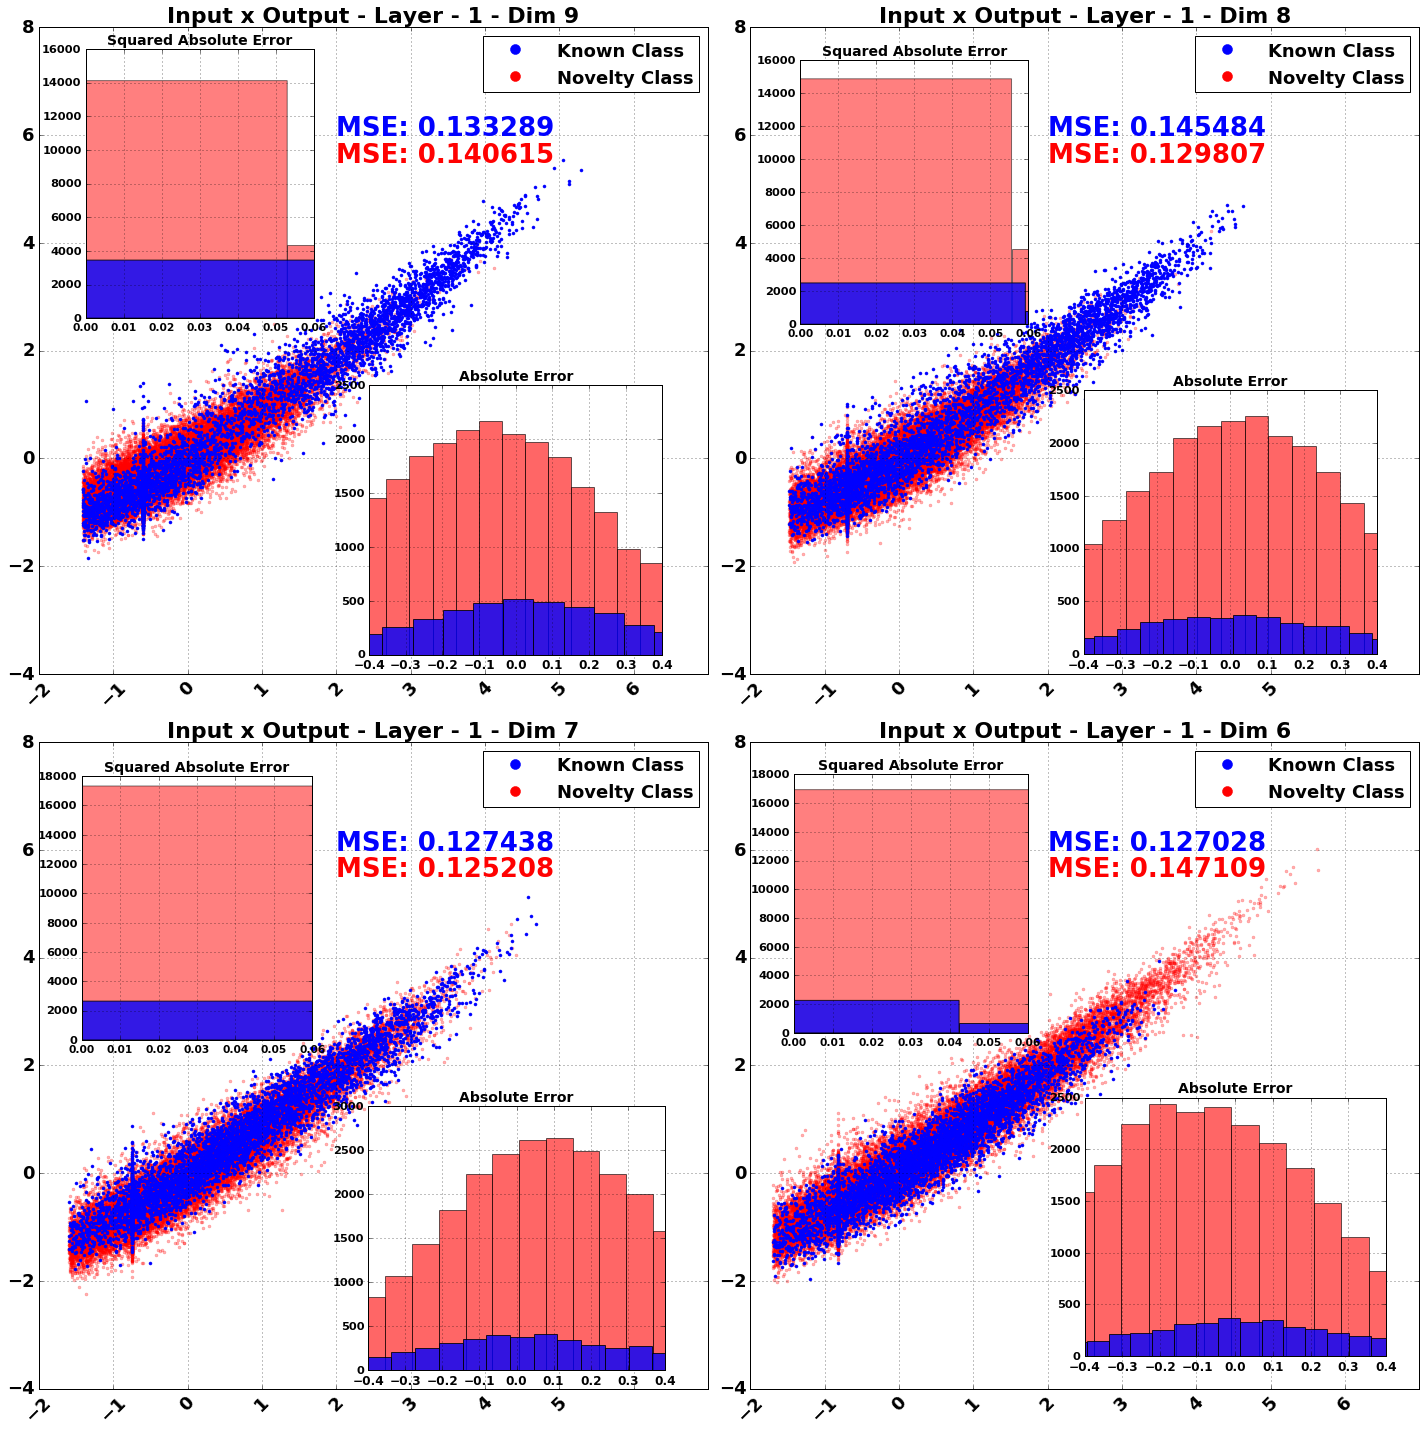

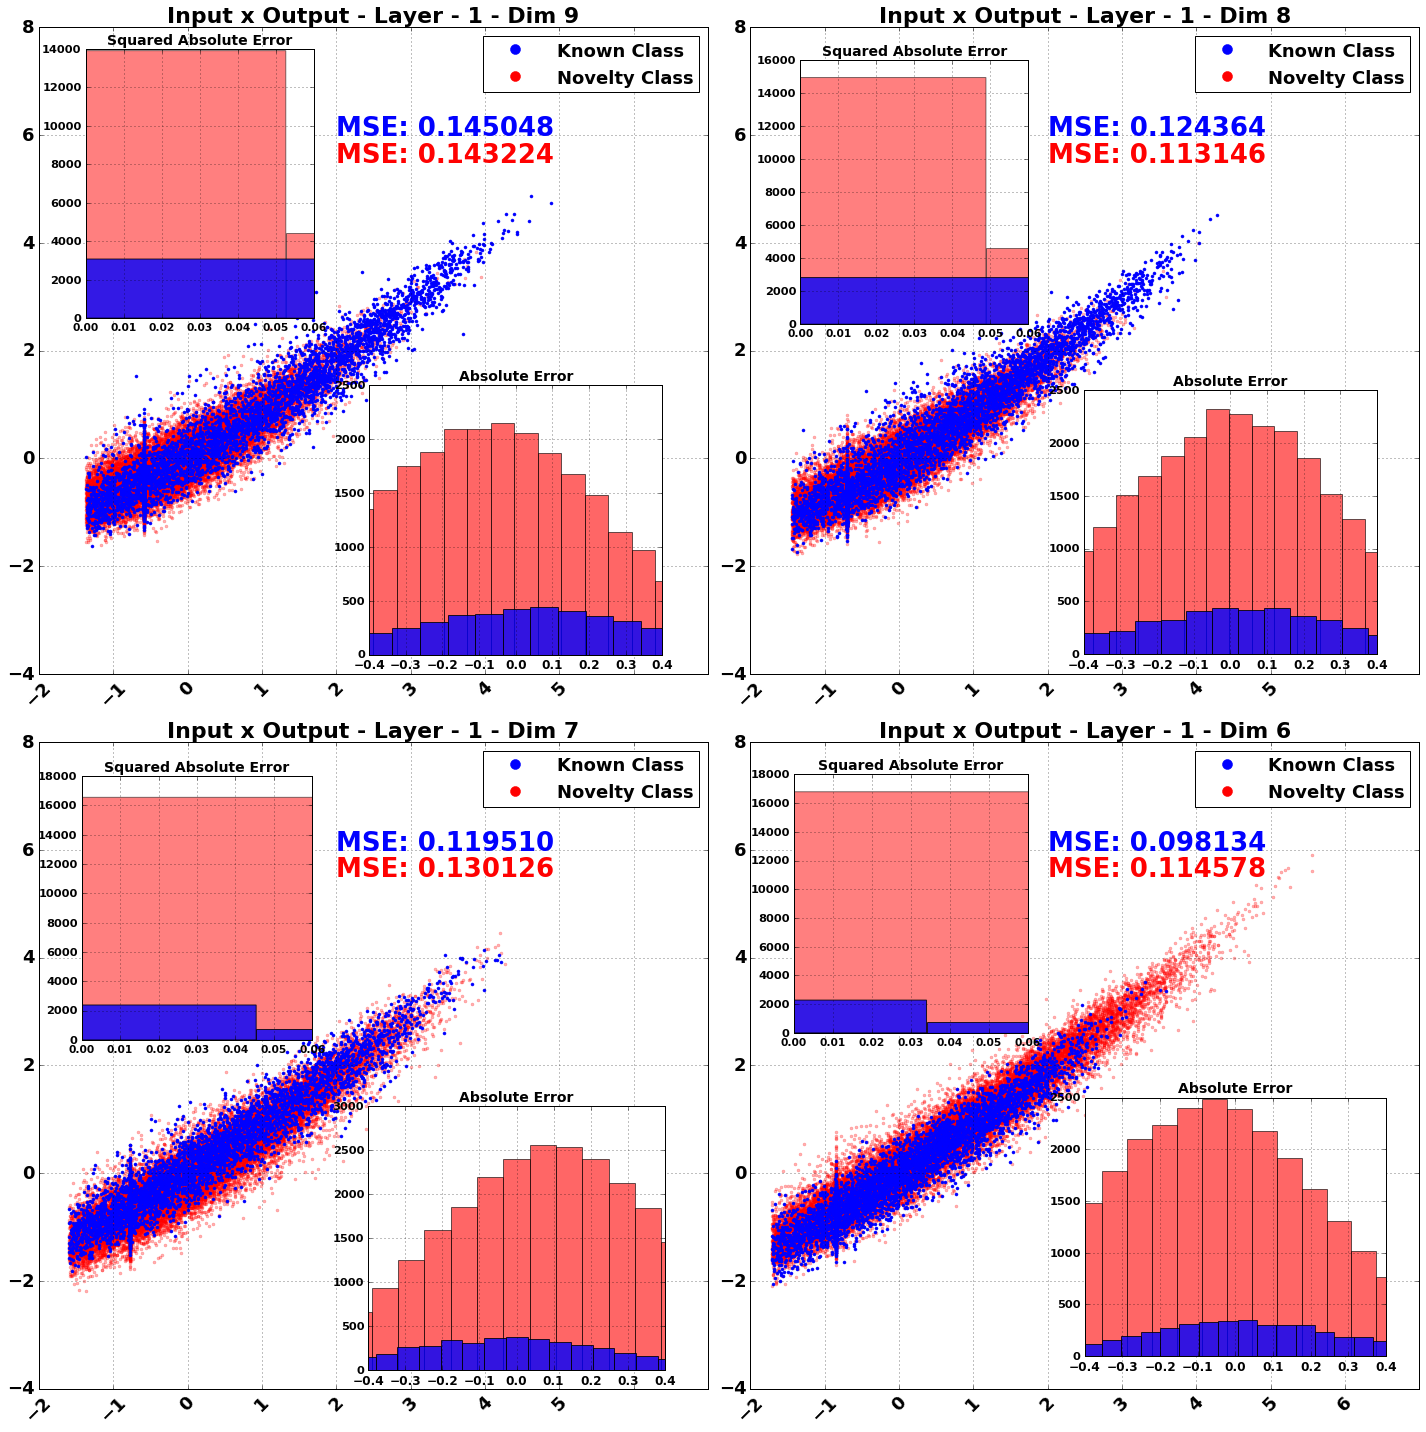

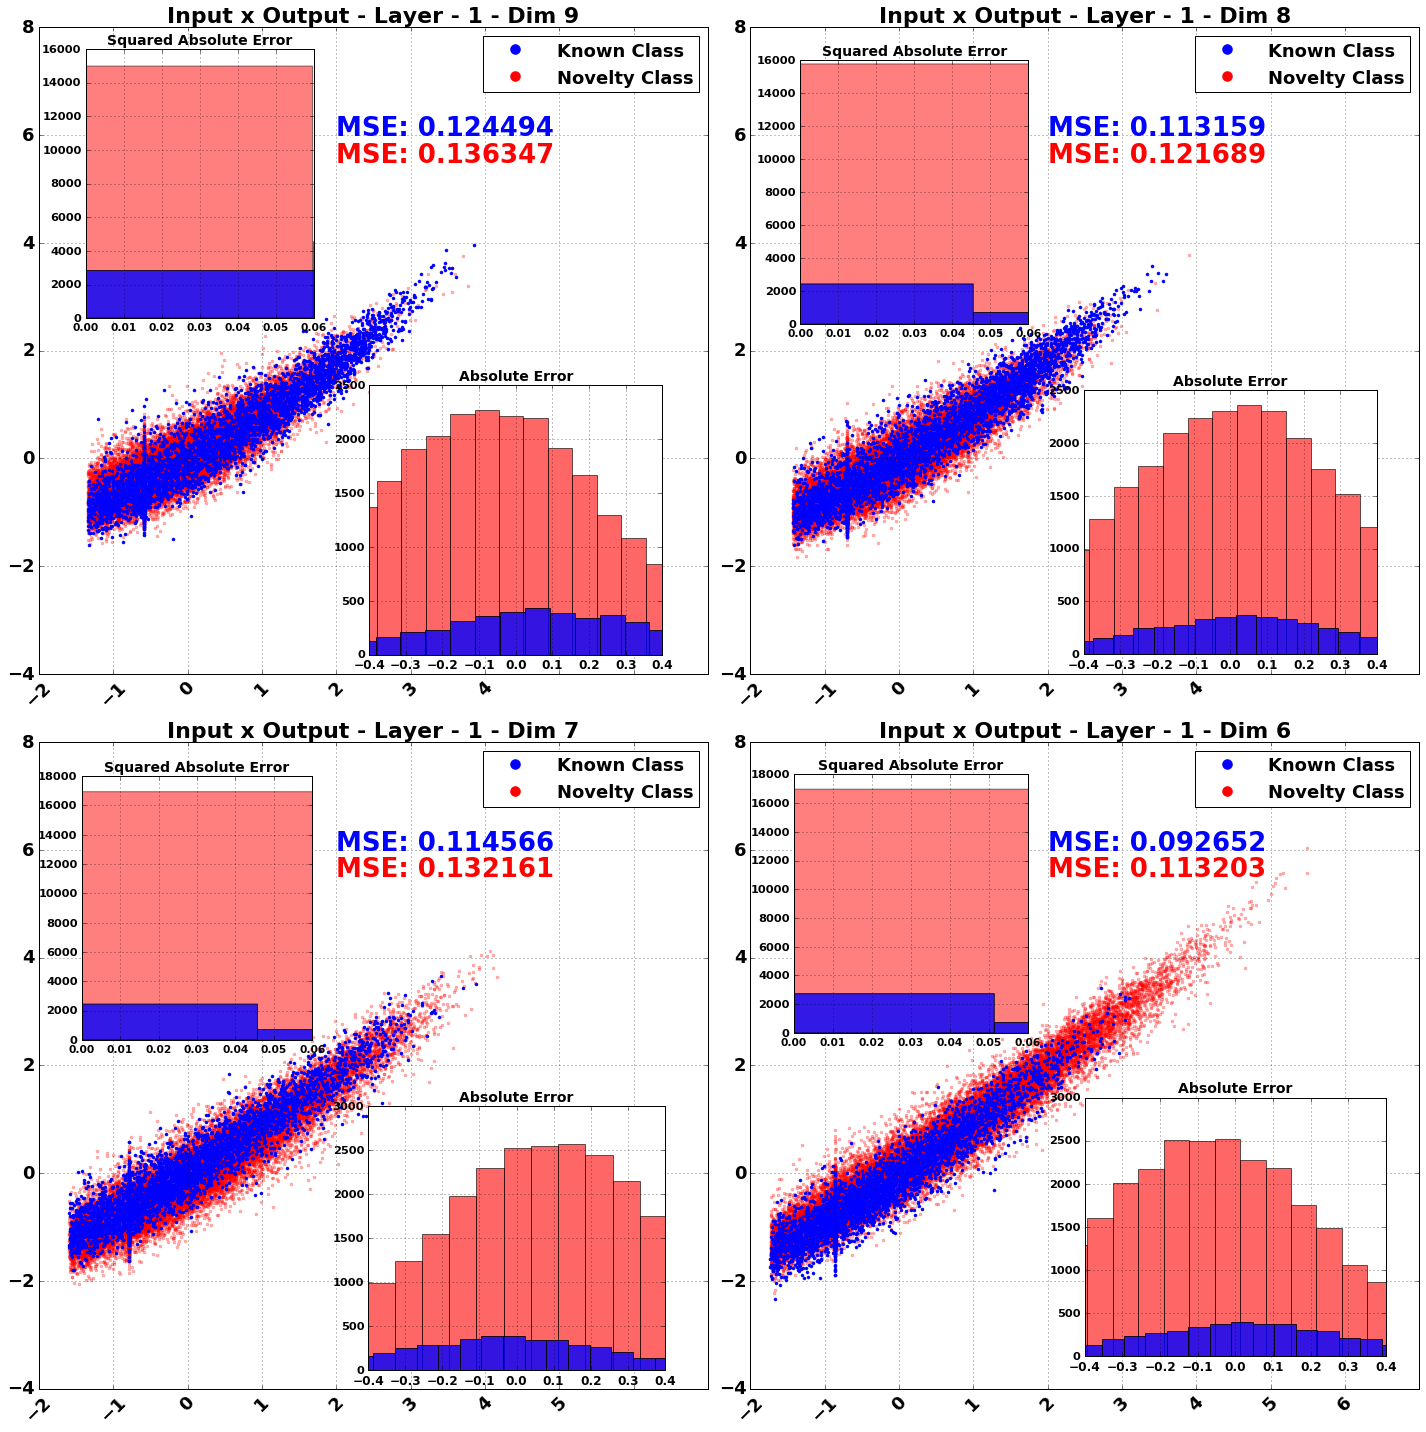

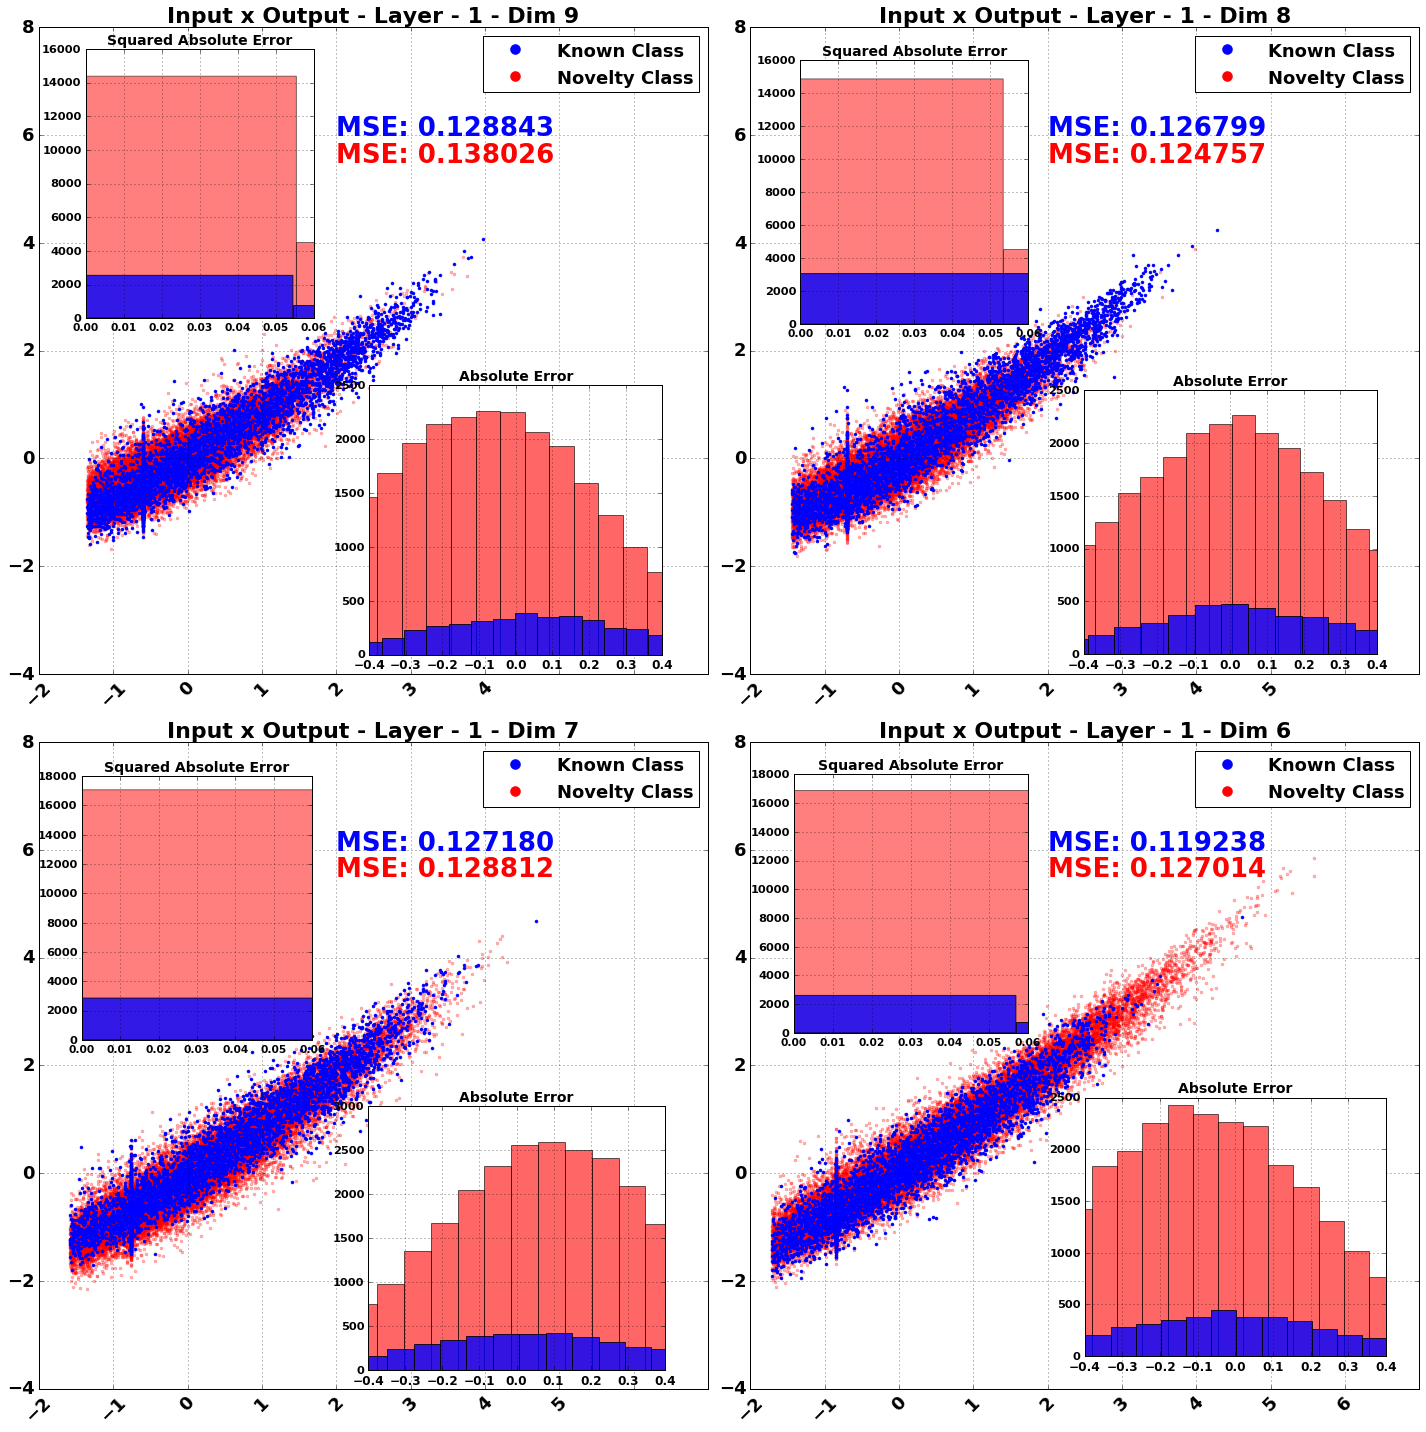

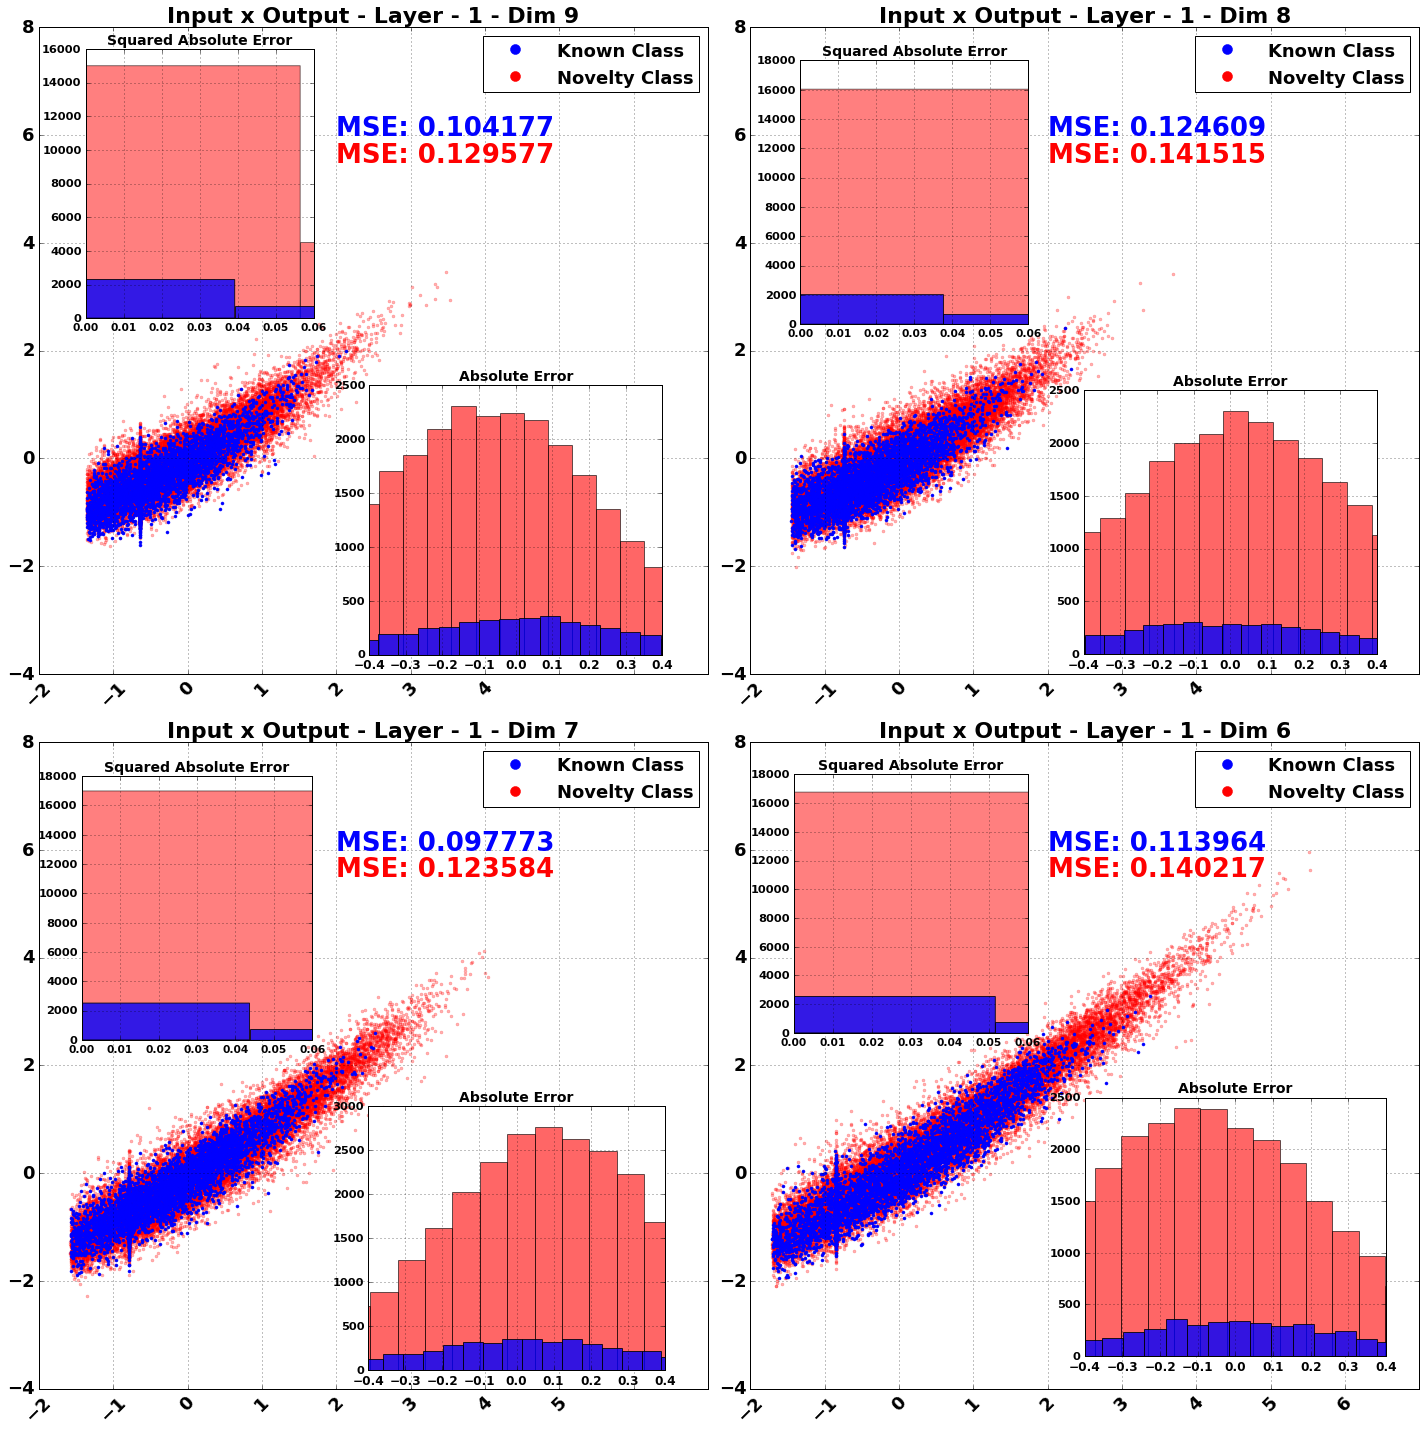

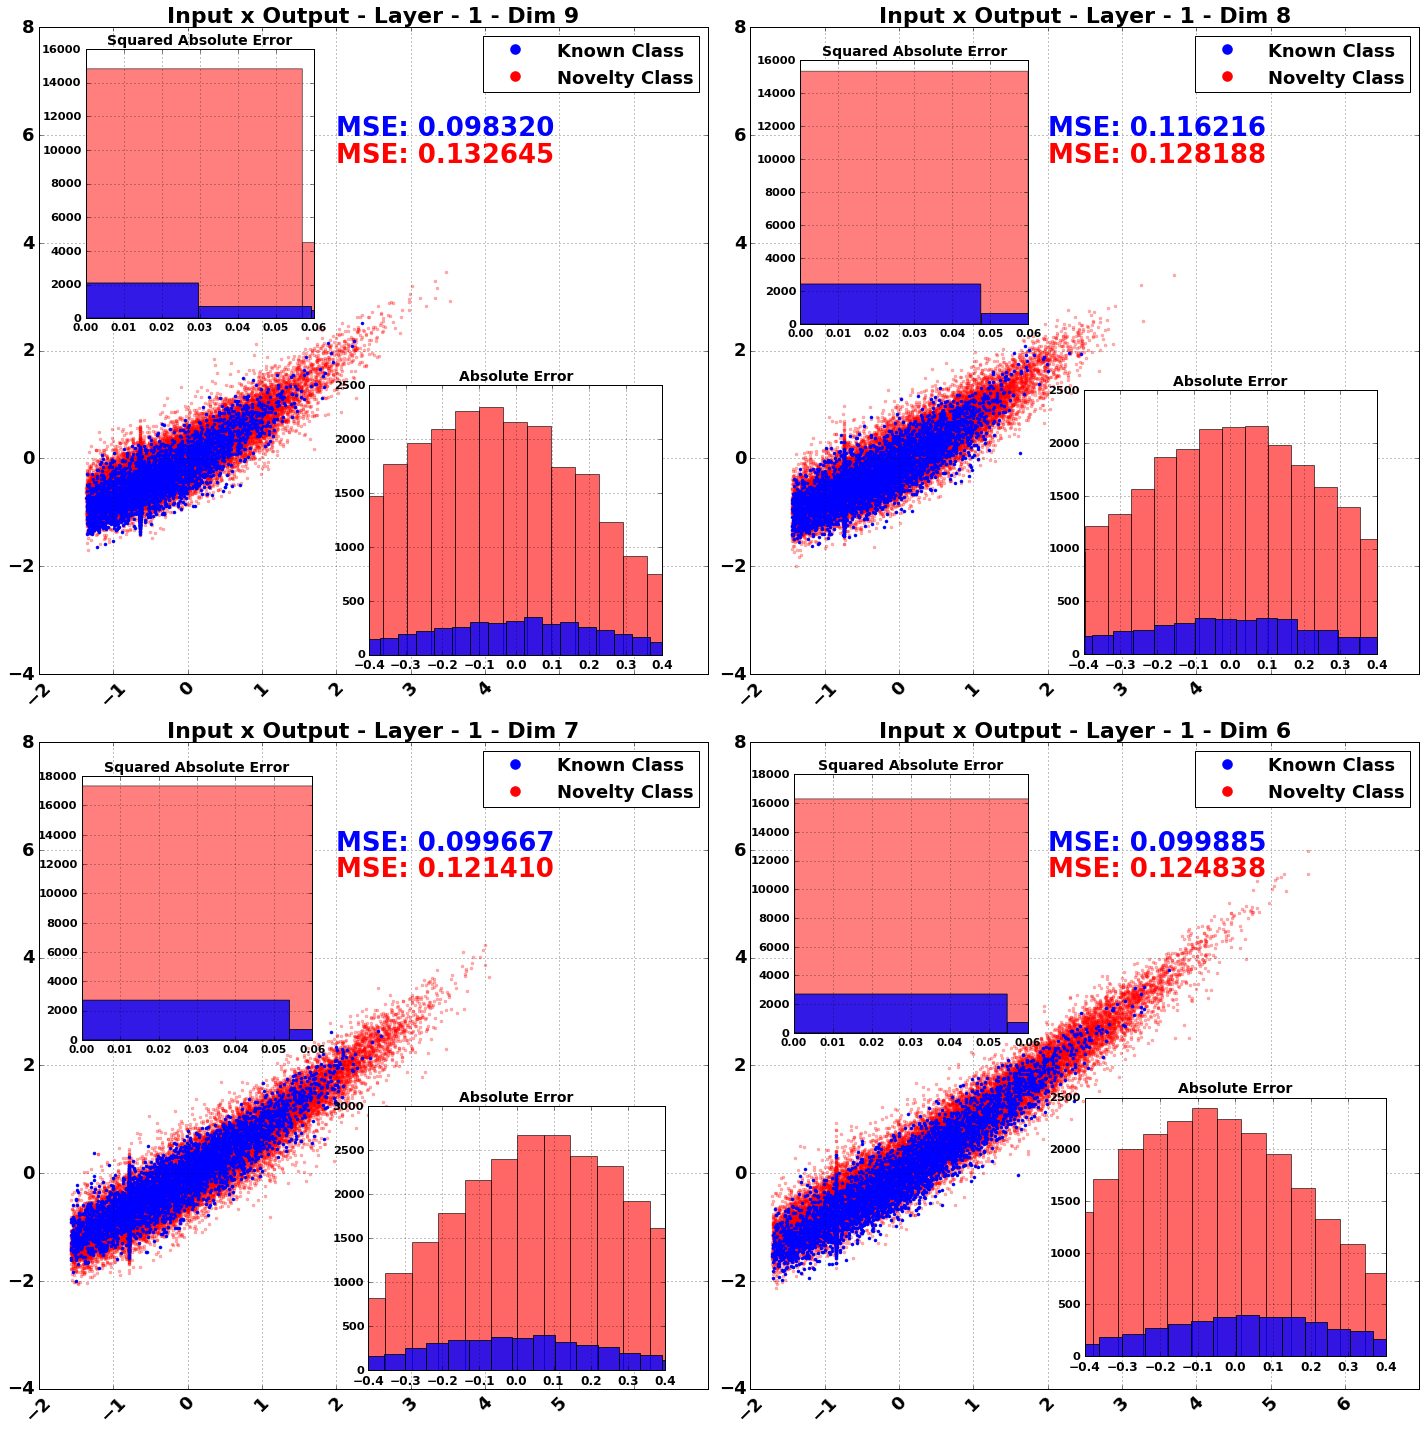

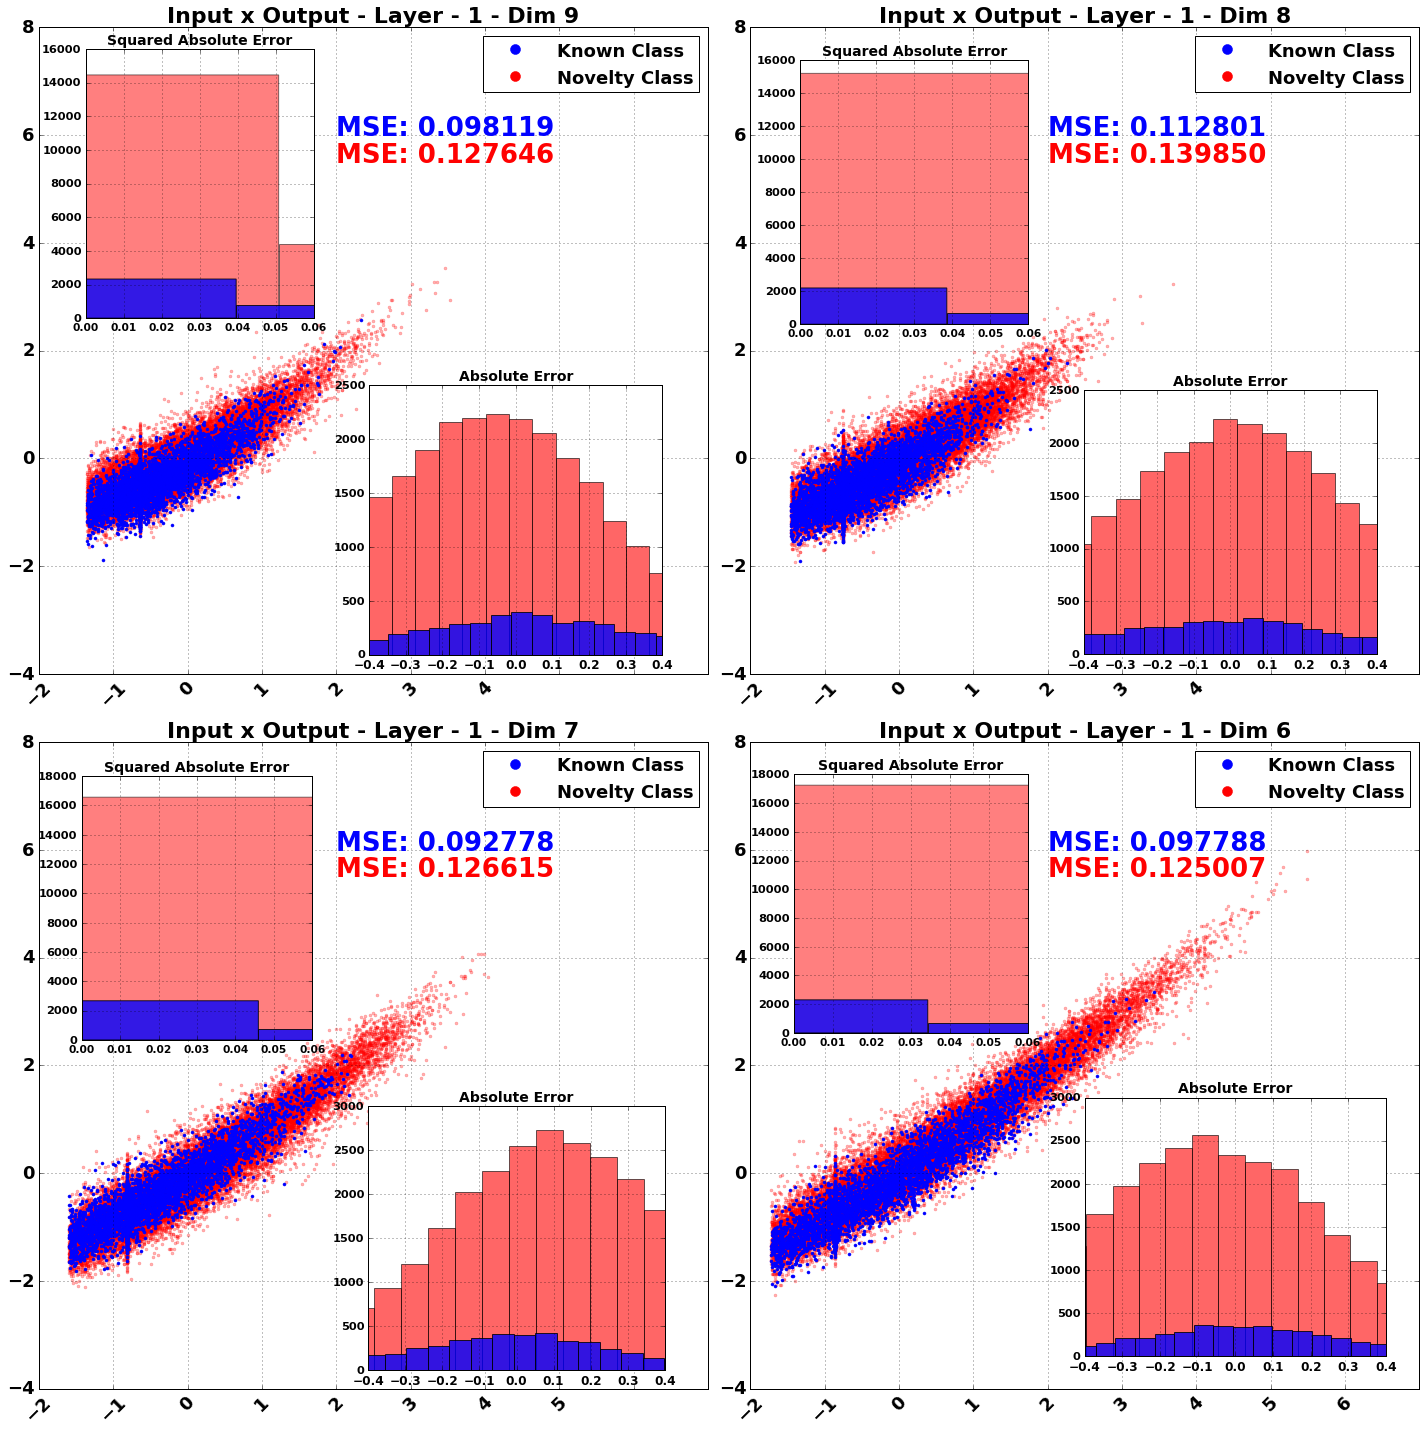

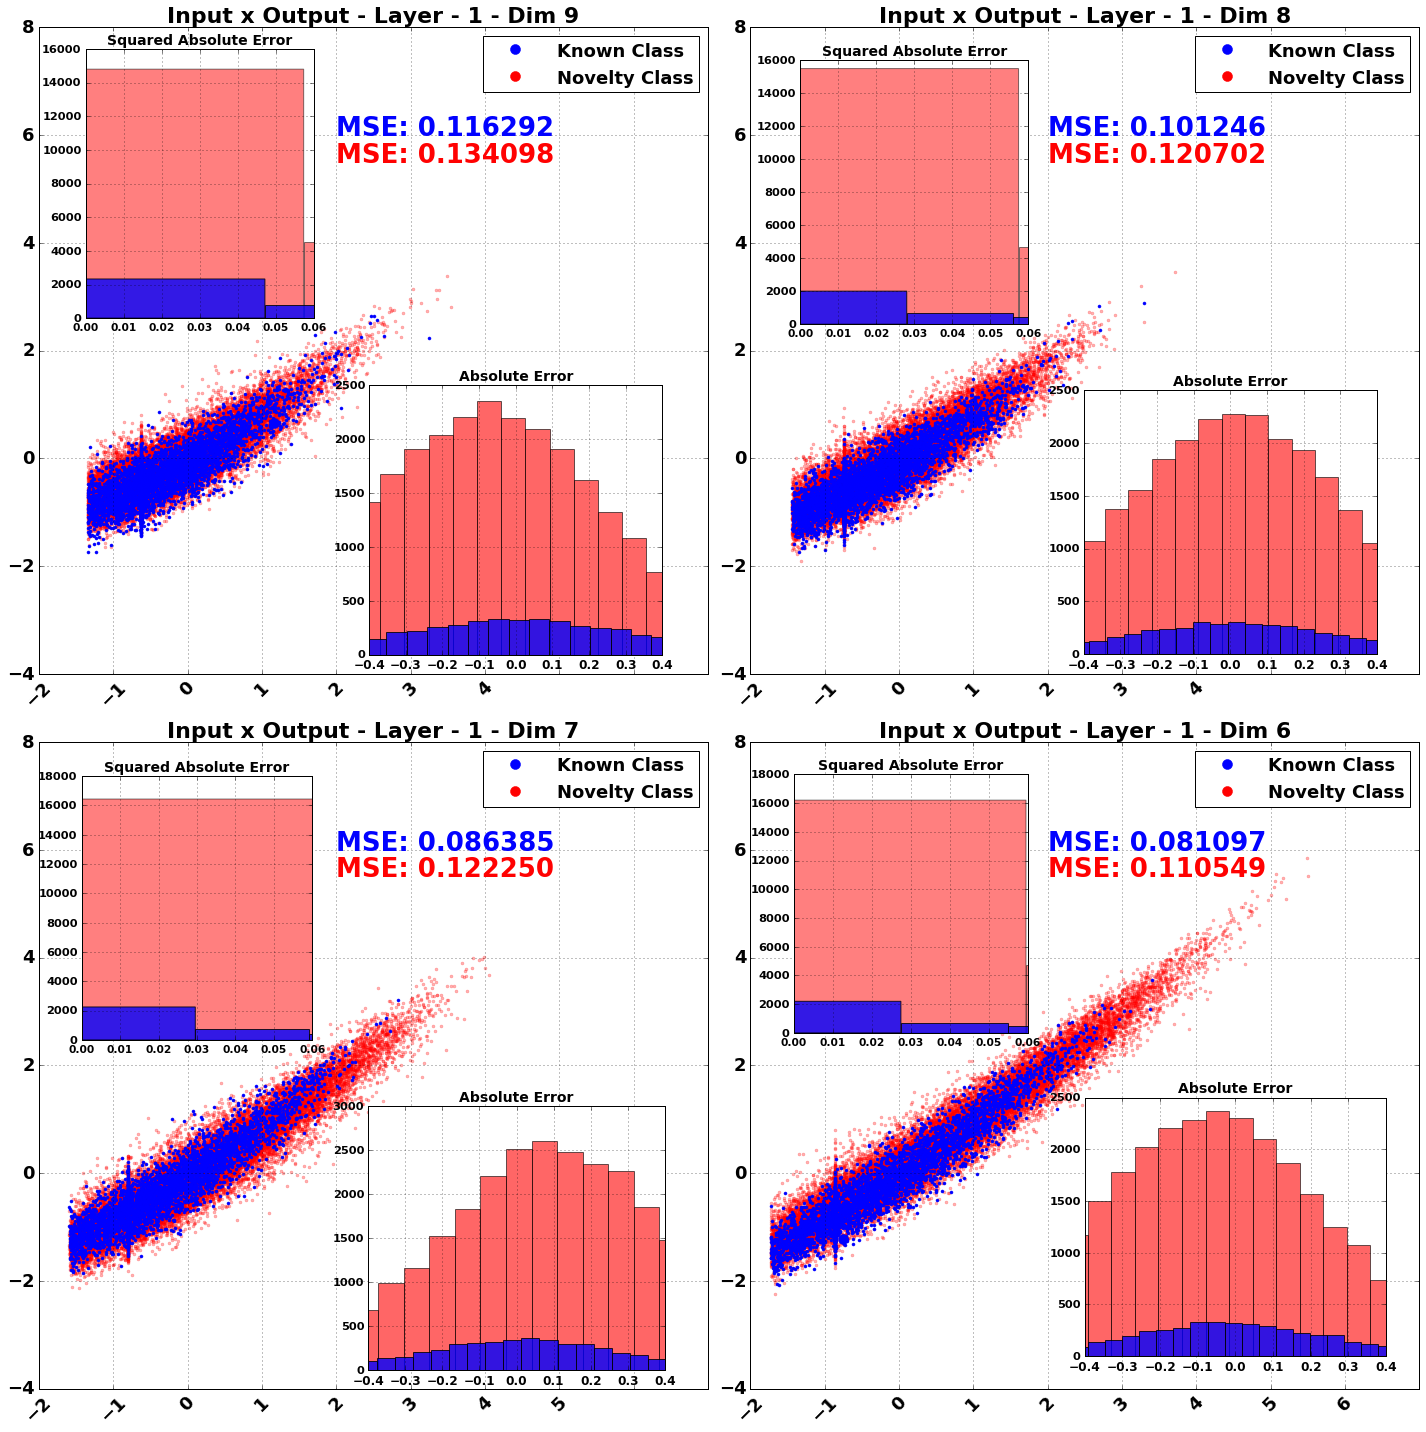

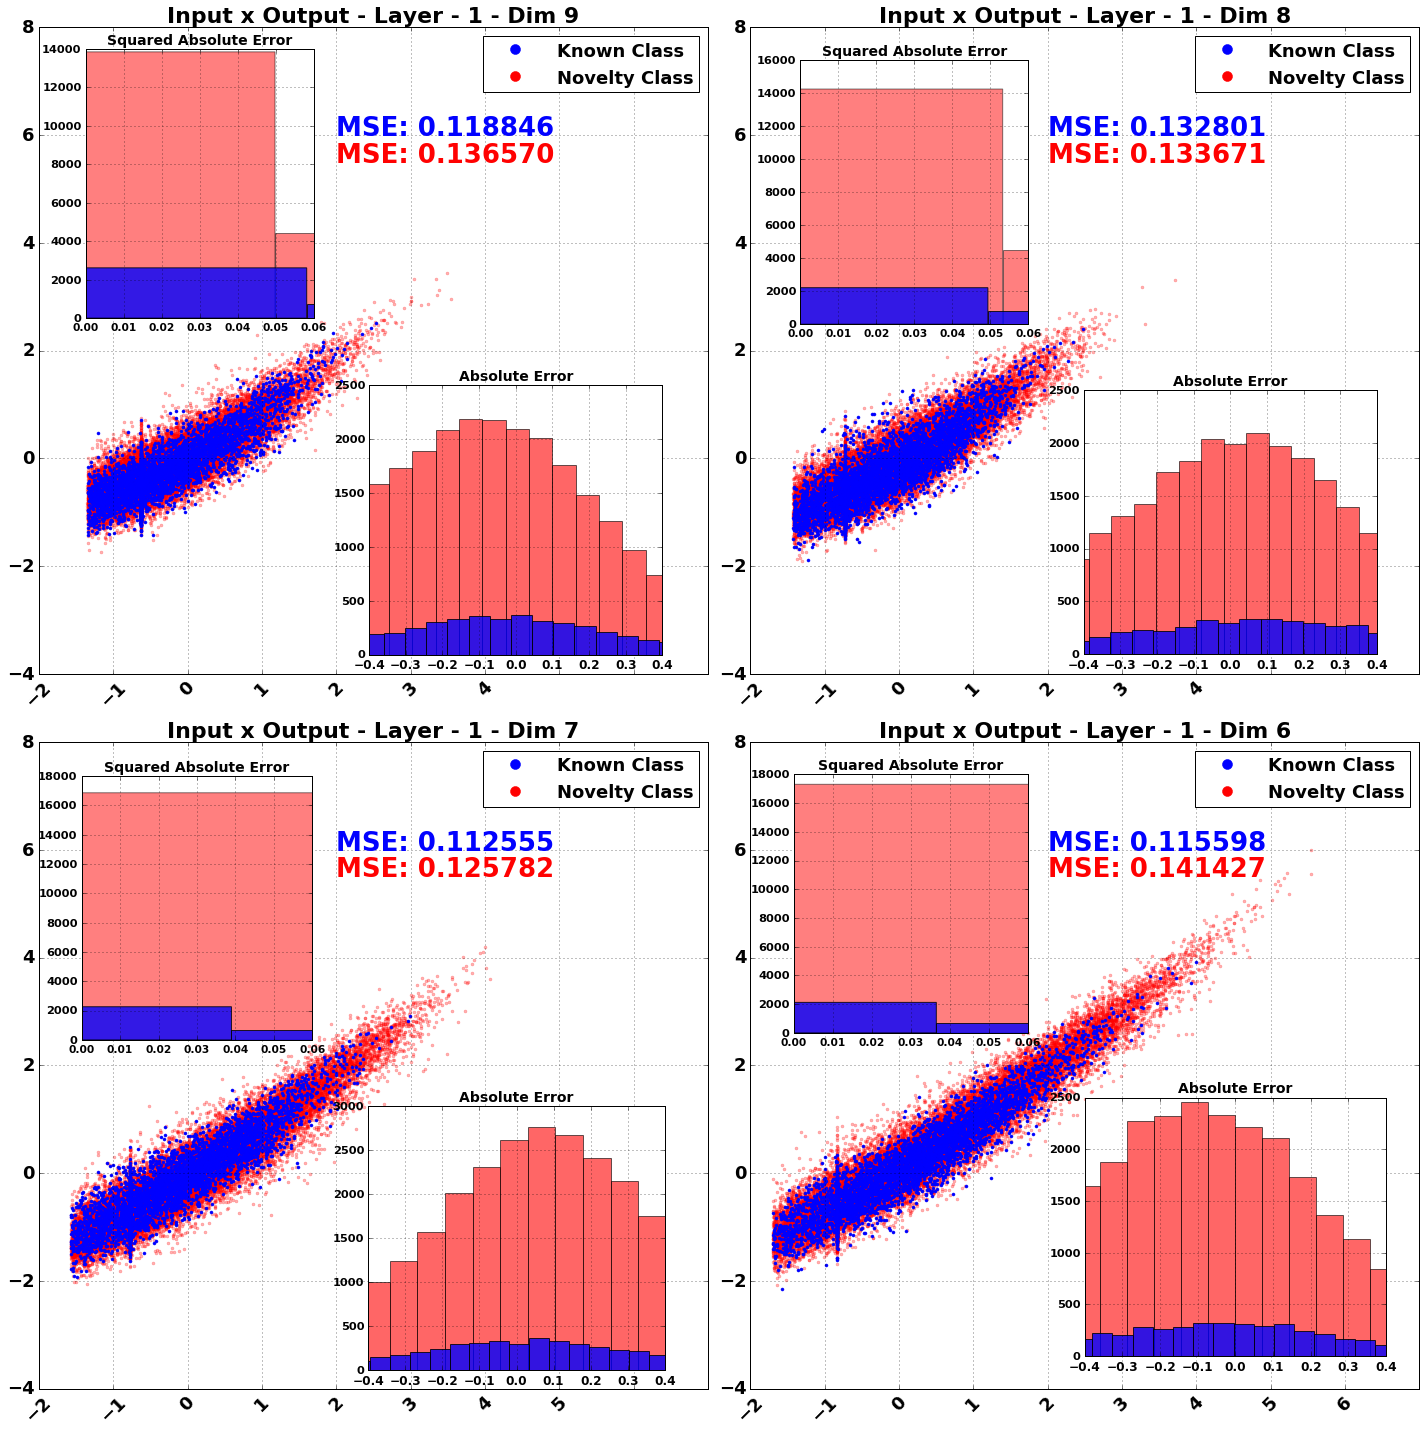

In [25]:
# Neuron variation x MSE Divergence
%matplotlib inline 

from sklearn import metrics
from sklearn import preprocessing
from sklearn.externals import joblib
from Functions.StatisticalAnalysis import KLDiv, EstPDF
from Functions import FunctionsDataVisualization
import matplotlib.pyplot as plt

# Choose layer 
layer = 1

# Choose neurons topology
#hidden_neurons = range(400,0,-50) + [2]

hidden_neurons = [300]

neurons_mat = [1] + range(step,hidden_neurons[layer-1]+step,step)
neurons_mat = neurons_mat[:len(neurons_mat)-layer+2]

analysis_name = 'scatter_plot_%i_layer_keras_class_weights'%(layer)
analysis_file = os.path.join(analysis.getBaseResultsPath(), "AnalysisFiles", analysis_name + ".jbl")    

verbose = True

# Choose model
inovelty = 1

# Plot parameters
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['legend.handlelength'] = 3
plt.rcParams['legend.borderpad'] = 0.3
plt.rcParams['legend.fontsize'] = 18
m_colors = ['b', 'r', 'g', 'y']


neurons_str = SAE[inovelty].get_neurons_str(all_data, hidden_neurons=hidden_neurons[:layer])

models = {}
known_outputs = {}
novelty_outputs = {}
mean = {}
indexes = {}

for ifold in range(analysis.parameters["HyperParameters"]["n_folds"]):
    train_id, test_id = analysis.CVO[inovelty][ifold]

    # normalize known classes
    if analysis.parameters["HyperParameters"]["norm"] == "mapstd":
        scaler = preprocessing.StandardScaler().fit(all_data[all_trgt!=inovelty][train_id,:])
    elif analysis.parameters["HyperParameters"]["norm"] == "mapstd_rob":
        scaler = preprocessing.RobustScaler().fit(all_data[all_trgt!=inovelty][train_id,:])
    elif analysis.parameters["HyperParameters"]["norm"] == "mapminmax":
        scaler = preprocessing.MinMaxScaler().fit(all_data[all_trgt!=inovelty][train_id,:])
        
    norm_data = scaler.transform(all_data)
    known_data = scaler.transform(trn_data[inovelty][test_id,:])
    novelty_data = scaler.transform(all_data[all_trgt==inovelty])
    
    if ifold == 0:
        diffSquared = np.zeros([analysis.parameters["HyperParameters"]["n_folds"], all_data.shape[0], all_data.shape[1]])
        
    print 'Novelty class: %i - Topology: %s - fold %i'%(inovelty, neurons_str, ifold)
    
    models[ifold] = SAE[inovelty].get_model(data=trn_data[inovelty], trgt=trn_trgt[inovelty],
                                            hidden_neurons=hidden_neurons,
                                            layer=layer, ifold=ifold)
    
    outputs = models[ifold].predict(norm_data)
    known_outputs[ifold] = models[ifold].predict(known_data)
    novelty_outputs[ifold] = models[ifold].predict(novelty_data)
    
    diffSquared[ifold,:,:] = np.power((norm_data - outputs), 2)

# Get the mean squared error on the folds    
mean = np.mean(np.mean(diffSquared[:,test_id,:], axis=0), axis=0)

# Sort the indexes that has the highest mean squared error
indexes = np.argsort(mean)[::-1]

for ifold in range(analysis.parameters["HyperParameters"]["n_folds"]):
    train_id, test_id = analysis.CVO[inovelty][ifold]

    # normalize known classes
    if analysis.parameters["HyperParameters"]["norm"] == "mapstd":
        scaler = preprocessing.StandardScaler().fit(all_data[all_trgt!=inovelty][train_id,:])
    elif analysis.parameters["HyperParameters"]["norm"] == "mapstd_rob":
        scaler = preprocessing.RobustScaler().fit(all_data[all_trgt!=inovelty][train_id,:])
    elif analysis.parameters["HyperParameters"]["norm"] == "mapminmax":
        scaler = preprocessing.MinMaxScaler().fit(all_data[all_trgt!=inovelty][train_id,:])
    norm_data = scaler.transform(all_data)
    known_data = scaler.transform(trn_data[inovelty][test_id,:])
    novelty_data = scaler.transform(all_data[all_trgt==inovelty])
    
    known_points = known_data.shape[0]
    novelty_points = novelty_data.shape[0]
    
    # Number of dimensions to analyse (even number is better!)
    num_dim = 4
    fig, m_ax = plt.subplots(figsize=(20,20),nrows=2, ncols=2)
    for choose_index in range(num_dim):  
        ax = plt.subplot(2,2,choose_index+1)
        
        # Plot novelty 
        ax.plot(novelty_data[:,indexes[choose_index]][0], 
                novelty_outputs[ifold][:,indexes[choose_index]][0],
                "r.", label='Novelty Class', markersize=20)
        ax.plot(novelty_data[:,indexes[choose_index]][:novelty_points], 
                novelty_outputs[ifold][:,indexes[choose_index]][:novelty_points],
                "r.", alpha=0.3)
        
        # Plot known classes
        ax.plot(known_data[:,indexes[choose_index]][0],
                known_outputs[ifold][:,indexes[choose_index]][0],
                "b.", label='Known Class', markersize=20)
        ax.plot(known_data[:,indexes[choose_index]][:known_points],
                known_outputs[ifold][:,indexes[choose_index]][:known_points],
                "b.")
        
        plt.tight_layout()
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        ax.set_title('Input x Output - Layer - %i - Dim %i'%(layer,indexes[choose_index]),fontsize=22, fontweight='bold')
        ax.set_xlim(-2, 7)
        ax.set_ylim(-4, 8)
        handles, labels = ax.get_legend_handles_labels()
        # sort both labels and handles by labels
        labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
        plt.grid() 
        
        # Small plot
        rect = [0.065, 0.55, 0.35, 0.4]
        ax1 = FunctionsDataVisualization.add_subplot_axes(ax,rect)
        
        eq_known_reconstruction = np.power((known_data[:,indexes[choose_index]] - known_outputs[ifold][:,indexes[choose_index]]), 2)
        eq_novelty_reconstruction = np.power((novelty_data[:,indexes[choose_index]] - novelty_outputs[ifold][:,indexes[choose_index]]), 2)
        
        mq_bins_known = np.linspace(np.min(eq_known_reconstruction), np.max(eq_known_reconstruction), 50)
        mq_bins_novelty = np.linspace(np.min(eq_novelty_reconstruction), np.max(eq_novelty_reconstruction), 50)
             
        n, bins, patches = ax1.hist(eq_novelty_reconstruction,bins=mq_bins_novelty,
                                    fc="r",
                                    alpha=0.5, normed=0)
        
        n, bins, patches = ax1.hist(eq_known_reconstruction,bins=mq_bins_known,
                                    fc="b",
                                    alpha=0.8, normed=0)   
        ax1.set_xlim(0, 0.06)
        ax1.set_title("Squared Absolute Error",fontsize=14, fontweight='bold')
        ax1.grid() 
        
        # Small plot
        rect = [0.5, 0.05, 0.45, 0.4]
        ax2 = FunctionsDataVisualization.add_subplot_axes(ax,rect)
        
        e_known_reconstruction = (known_data[:,indexes[choose_index]] - known_outputs[ifold][:,indexes[choose_index]])
        e_novelty_reconstruction = (novelty_data[:,indexes[choose_index]] - novelty_outputs[ifold][:,indexes[choose_index]])
        
        m_bins_known = np.linspace(np.min(e_known_reconstruction), np.max(e_known_reconstruction), 50)
        m_bins_novelty = np.linspace(np.min(e_novelty_reconstruction), np.max(e_novelty_reconstruction), 50)
        
        n, bins, patches = ax2.hist(e_novelty_reconstruction,bins=m_bins_novelty,
                                    fc="r",
                                    alpha=0.6, normed=0)
        
        n, bins, patches = ax2.hist(e_known_reconstruction,bins=m_bins_known,
                                    fc="b",
                                    alpha=0.8, normed=0)   
        ax2.grid()
        ax2.set_title("Absolute Error",fontsize=14, fontweight='bold')
        ax2.set_xlim(-0.4,0.4) 
        
        ax.legend(handles, labels, ncol=1, loc='upper right')
        plt.legend()

        mse = metrics.mean_squared_error(known_data[:,indexes[choose_index]], known_outputs[ifold][:,indexes[choose_index]])
        ax.text(2, 6, 'MSE: %f'%mse, style='normal',fontsize=26, color='blue',
        bbox={'alpha':0.0, 'pad':10})
        
        mse = metrics.mean_squared_error(novelty_data[:,indexes[choose_index]], novelty_outputs[ifold][:,indexes[choose_index]])
        ax.text(2, 5.5, 'MSE: %f'%mse, style='normal',fontsize=26, color='red',
        bbox={'alpha':0.0, 'pad':10})
        
        #Save the figure
#         file_name = pict_results_path+'/'+current_analysis+'_%i_novelty_%i_layer_%s_neurons_%i_fold_'%(inovelty,
#                                                                                                        layer,
#                                                                                                        neurons_str,
#                                                                                                        ifold)+trn_params.get_params_str()+'.pdf'
#         plt.savefig(file_name)
    plt.show()

# Fine Tuning Analysis

### SP Index analysis for a Fine Tuning Step with a neuron variation at autoencoder

[*] Calculating SP Index ...
[*] Calculating SP Index ...
[*] Calculating SP Index ...
[*] Calculating SP Index ...
[*] Calculating SP Index ...
[*] Calculating SP Index ...
[*] Calculating SP Index ...
[*] Calculating SP Index ...
[*] Calculating SP Index ...
[*] Calculating SP Index ...
[*] Calculating SP Index ...
[*] Calculating SP Index ...
[*] Calculating SP Index ...
[*] Calculating SP Index ...
[*] Calculating SP Index ...
[*] Calculating SP Index ...
[*] Calculating SP Index ...
[*] Calculating SP Index ...
[*] Calculating SP Index ...
[*] Calculating SP Index ...


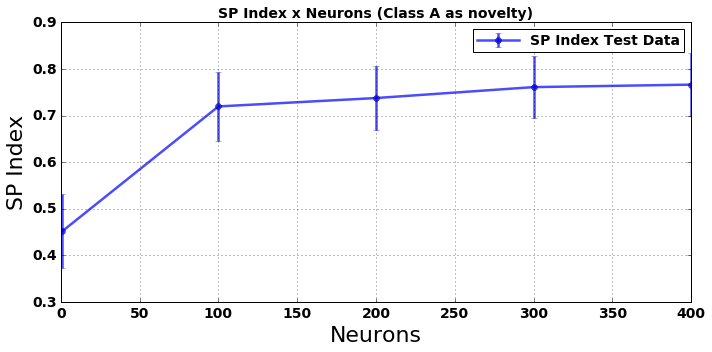

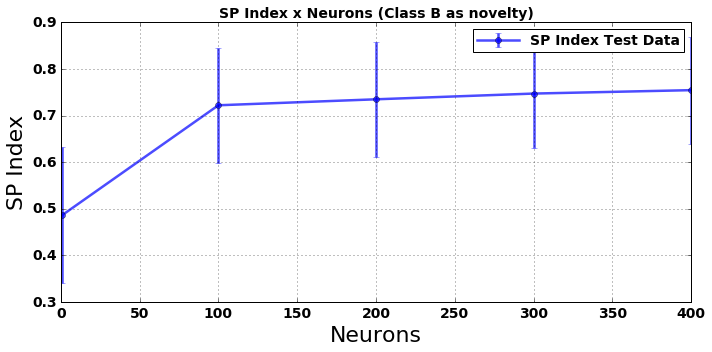

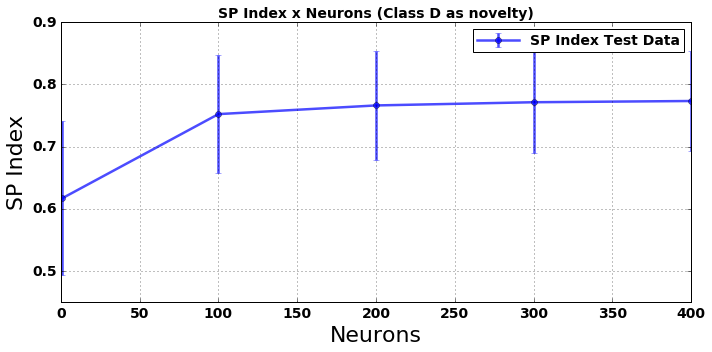

In [15]:
%matplotlib inline 

from sklearn import metrics
from sklearn import preprocessing
from sklearn.externals import joblib
from Functions.StatisticalAnalysis import KLDiv, EstPDF
import matplotlib.pyplot as plt

# Choose layer 
layer = 1

# Choose neurons topology
hidden_neurons = range(400,0,-50) + [2]

step = 100
neurons_mat = [1] + range(step,hidden_neurons[layer-1]+step,step)
neurons_mat = neurons_mat[:len(neurons_mat)-layer+2]

analysis_name = 'sp_index_%i_layer_keras_class_weights'%(layer)
analysis_file = os.path.join(analysis.getBaseResultsPath(), "AnalysisFiles", analysis_name + ".jbl")    

verbose = True

# Plot parameters
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['legend.handlelength'] = 3
plt.rcParams['legend.borderpad'] = 0.3
plt.rcParams['legend.fontsize'] = 14
m_colors = ['b', 'r', 'g', 'y']
figsize = (10,5)


results = {}
spIndex = np.zeros([len(analysis.class_labels), analysis.parameters["HyperParameters"]["n_folds"], len(neurons_mat)])

if not os.path.exists(analysis_file):
    for inovelty in range(len(analysis.class_labels)):
        for ineuron in neurons_mat: 
            if ineuron == 0:
                ineuron = 1        
            class_eff_mat = np.zeros([analysis.parameters["HyperParameters"]["n_folds"],len(np.unique(all_trgt))])
            known_sp_mat = np.zeros([analysis.parameters["HyperParameters"]["n_folds"]])

            buff = np.zeros([len(np.unique(all_trgt))-1])
            class_eff = np.zeros([len(np.unique(all_trgt))], dtype=object)
            known_sp = np.zeros([len(np.unique(all_trgt))], dtype=object)

            def getSP(ifold):
                train_id, test_id = analysis.CVO[inovelty][ifold]

                # normalize known classes
                if analysis.parameters["HyperParameters"]["norm"] == "mapstd":
                    scaler = preprocessing.StandardScaler().fit(all_data[all_trgt!=inovelty][train_id,:])
                elif analysis.parameters["HyperParameters"]["norm"] == "mapstd_rob":
                    scaler = preprocessing.RobustScaler().fit(all_data[all_trgt!=inovelty][train_id,:])
                elif analysis.parameters["HyperParameters"]["norm"] == "mapminmax":
                    scaler = preprocessing.MinMaxScaler().fit(all_data[all_trgt!=inovelty][train_id,:])

                known_data = scaler.transform(analysis.trn_data[inovelty][test_id,:])
                known_trgt = analysis.trn_trgt[inovelty][test_id]
                classifier = SAE[inovelty].load_classifier(data  = analysis.trn_data[inovelty],
                                                           trgt  = analysis.trn_trgt[inovelty], 
                                                           hidden_neurons = hidden_neurons[:layer-1]+[ineuron],
                                                           layer = layer,
                                                           ifold = ifold)

                output = classifier.predict(known_data)

                num_known_classes = analysis.trn_trgt_sparse[inovelty].shape[1]
                thr_value = 0.2
                for iclass, class_id in enumerate(np.unique(all_trgt)):
                    if iclass == inovelty:
                        continue
                    output_of_class_events = output[known_trgt==iclass-(iclass>inovelty),:]
                    correct_class_output = np.argmax(output_of_class_events,axis=1)==iclass-(iclass>inovelty)
                    output_above_thr = output_of_class_events[correct_class_output,iclass-(iclass>inovelty)]>thr_value
                    class_eff = float(sum(output_above_thr))/float(len(output_of_class_events))
                    buff[iclass-(iclass>inovelty)] = class_eff

                sp_index = (np.sqrt(np.mean(buff,axis=0)*np.power(np.prod(buff),1./float(len(buff)))))
                
                return ifold, sp_index

            # Start Parallel processing
            p = multiprocessing.Pool(processes=num_processes)

            folds = range(len(analysis.CVO[inovelty]))
            if verbose:
                print '[*] Calculating SP Index ...'
            results[ineuron] = p.map(getSP, folds)

            for ifold in range(analysis.parameters["HyperParameters"]["n_folds"]):
                spIndex[inovelty, ifold, neurons_mat.index(ineuron)] = results[ineuron][ifold][1]

            p.close()
            p.join()

    joblib.dump([neurons_mat,spIndex],analysis_file,compress=9)
else:
    [neurons_mat, spIndex] = joblib.load(analysis_file_name)

    
for inovelty in range(len(analysis.class_labels)):
    # Plot results    
    fig = plt.subplots(figsize=figsize)
    ax = plt.subplot(1,1,1)
    
    ax.errorbar(neurons_mat, np.mean(spIndex[inovelty,:], axis=0),
                np.std(spIndex[inovelty,:,:], axis=0),fmt='o-',
                color='b',alpha=0.7,linewidth=2.5,
                label='SP Index Test Data')
    
    ax.set_title('SP Index x Neurons (Class {} as novelty)'.format(analysis.class_labels[inovelty]),
                                  fontsize=14, fontweight='bold')
    ax.set_ylabel('SP Index', fontsize=22)
    ax.set_xlabel('Neurons', fontsize=22)
    ax.grid()
    ax.legend()
    plt.tight_layout()
plt.show()

## Receiver Operating Characteristic (ROC) Curve for SP/Trigger with Novelty Detection